In [811]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, scale
import sklearn.metrics as skm
from imblearn.over_sampling import SMOTE
import random

np.random.seed(42)
random.seed(42)

In [812]:
# Set to true if figures should be saved and tables printed as latex
save = False

# Task 2: predict 'frustation' from heart-rate signal

Reading data

In [813]:
df = pd.read_csv('HR_data.csv')
hr_features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
features = ['Round','Phase','Puzzler', 'Cohort']

Encoding and binarization

In [814]:
encoder = LabelEncoder()
df['Phase'] = encoder.fit_transform(df['Phase'])
df['Round'] = encoder.fit_transform(df['Round'])
df['Cohort'] = encoder.fit_transform(df['Cohort'])

df['Frustrated'] = np.where(df['Frustrated']<4, 0, 1)

Correlation matrix

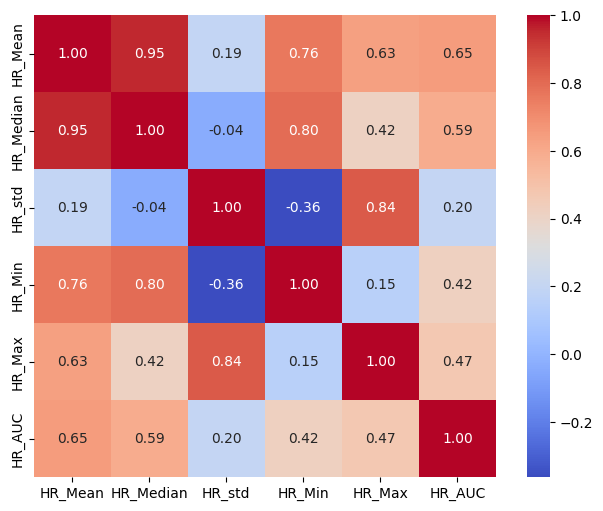

In [815]:
from seaborn import heatmap
correlation_matrix = df[hr_features].corr('pearson')

plt.figure(figsize=(8, 6))
heatmap = heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
if save:
    plt.savefig('correlation_matrix_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

PCA on standardized features

In [816]:
from sklearn.decomposition import PCA

X = df[hr_features]

pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(scale(X))

print('Number of components:', pca.n_components_)
print('Explained variance:', np.sum(pca.explained_variance_ratio_))

Number of components: 3
Explained variance: 0.9681845289365266


Class balance

In [817]:
print('Class 0:', len(df.loc[df['Frustrated']==0]))
print('Class 1:', len(df.loc[df['Frustrated']==1]))

Class 0: 121
Class 1: 47


Cross validation of models

In [818]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm

y = df['Frustrated']

groups = df['Individual']

individual_groups = GroupKFold(n_splits=7)

individual_groups.get_n_splits(X_pca, y, groups)

models = [DummyClassifier(strategy='most_frequent'), RandomForestClassifier(n_estimators=500), DecisionTreeClassifier()]

accuracy_list, recall_list = [], []
confit_mean_accuracy, confit_std_accuracy = [], []
confit_mean_recall, confit_std_recall = [], []
confusion_matrix_list = []
for model in models:
    print(model.__class__.__name__ )
    scores, recall = [], []
    cv=individual_groups.split(X_pca, y, groups)
    confusion_matrix = {'TP': 0, 'TN': 0, 'FP': 0, 'FN':0}
    for train_index, test_index in cv:
        X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], y[train_index], y[test_index]
        if model.__class__.__name__  != 'DummyClassifier':
            sm = SMOTE()
            X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
            model.fit(X_train_oversampled, y_train_oversampled)
        else: 
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)

        TN, FP, FN, TP = skm.confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        confusion_matrix['TP'] += TP
        confusion_matrix['TN'] += TN
        confusion_matrix['FP'] += FP
        confusion_matrix['FN'] += FN

        scores.append(skm.accuracy_score(y_test, y_pred))
        recall.append(skm.recall_score(y_test, y_pred, labels=[0,1]))

    if np.var(scores) != 0:
        boot_mean_accuracy = st.bootstrap((scores,), np.mean, n_resamples=1000000)
        mean_accuracy = (boot_mean_accuracy.confidence_interval.low, boot_mean_accuracy.confidence_interval.high)
        boot_std_accuracy = st.bootstrap((scores,), np.std, n_resamples=1000000)
        std_accuracy = (boot_std_accuracy.confidence_interval.low, boot_std_accuracy.confidence_interval.high)
    else:
        mean_accuracy = (np.mean(scores), np.mean(scores))
        std_accuracy = (np.std(scores), np.std(scores))

    if np.var(recall) != 0:
        boot_mean_recall = st.bootstrap((recall,), np.mean, n_resamples=1000000)
        mean_recall = (boot_mean_recall.confidence_interval.low, boot_mean_recall.confidence_interval.high)
        boot_std_recall = st.bootstrap((recall,), np.std, n_resamples=1000000)
        std_recall = (boot_std_recall.confidence_interval.low, boot_std_recall.confidence_interval.high)
    else:
        mean_recall = (np.mean(recall), np.mean(recall))
        std_recall = (np.std(recall), np.std(recall))

    print('Confidence interval mean accuracy:', mean_accuracy)
    print('Confidence interval std accuracy:', std_accuracy)
    print('Confidence interval mean recall:', mean_recall)
    print('Confidence interval std recall:', std_recall)
    print('')

    accuracy_list.append(scores)
    recall_list.append(recall)
    confit_mean_accuracy.append(mean_accuracy)
    confit_std_accuracy.append(std_accuracy)
    confit_mean_recall.append(mean_recall)
    confit_std_recall.append(std_recall)
    confusion_matrix_list.append(confusion_matrix)

DummyClassifier
Confidence interval mean accuracy: (0.6547619047619049, 0.7678571428571429)
Confidence interval std accuracy: (0.05189165408976992, 0.1030982623552903)
Confidence interval mean recall: (0.0, 0.0)
Confidence interval std recall: (0.0, 0.0)

RandomForestClassifier
Confidence interval mean accuracy: (0.5952380952380951, 0.744047619047619)
Confidence interval std accuracy: (0.0668153104781061, 0.12371791482634838)
Confidence interval mean recall: (0.3464285714285714, 0.7619047619047619)
Confidence interval std recall: (0.19474385758741458, 0.34251802011618077)

DecisionTreeClassifier
Confidence interval mean accuracy: (0.5654761904761904, 0.6785714285714286)
Confidence interval std accuracy: (0.04835737145616642, 0.10309826235529035)
Confidence interval mean recall: (0.3071428571428571, 0.5285714285714286)
Confidence interval std recall: (0.10251928638862373, 0.1924599083615354)



Confusion matrix

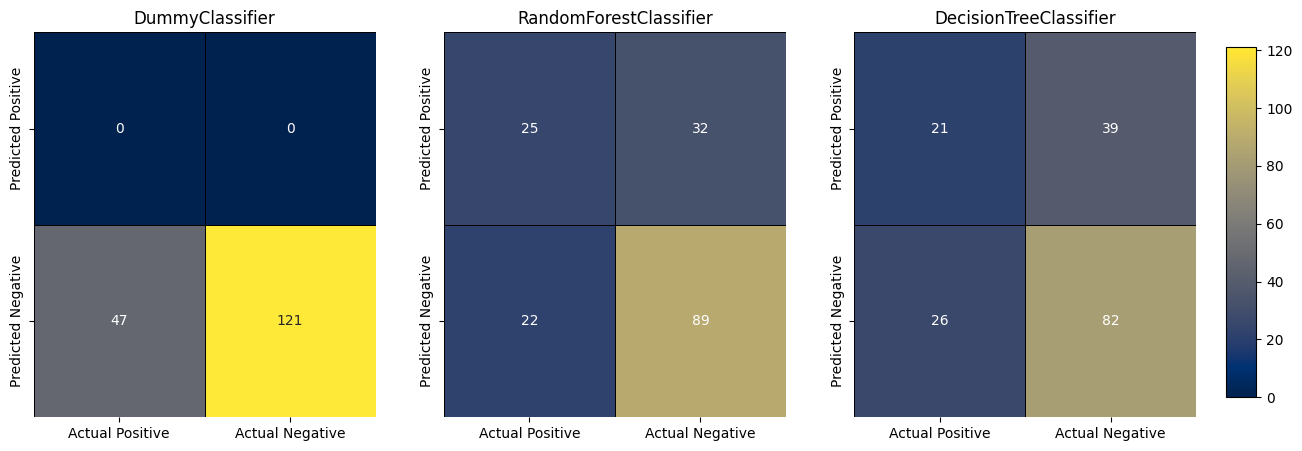

In [819]:
from seaborn import heatmap
# Determine the global min and max values for the color scale
all_values = []
for confusion_matrix in confusion_matrix_list:
    all_values.extend([confusion_matrix['TP'], confusion_matrix['FN'], confusion_matrix['FP'], confusion_matrix['TN']])

global_min = min(all_values)
global_max = max(all_values)

# Create a new figure for plotting
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

# Plot the confusion matrices
for i, model in enumerate(models):
    confusion_matrix = confusion_matrix_list[i]
    cm_array = np.array([[confusion_matrix['TP'], confusion_matrix['FP']], 
                         [confusion_matrix['FN'], confusion_matrix['TN']]])

    # Create a heatmap for each model
    heatmap(cm_array, annot=True, fmt='d', cmap='cividis', linewidths=0.5, linecolor='black',
                xticklabels=['Actual Positive', 'Actual Negative'],
                yticklabels=['Predicted Positive', 'Predicted Negative'], 
                vmin=global_min, vmax=global_max, ax=axes[i], cbar=False)
    axes[i].set_title(model.__class__.__name__)

# Add a single color bar to the side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(plt.cm.ScalarMappable(cmap='cividis', norm=plt.Normalize(vmin=global_min, vmax=global_max)), cax=cbar_ax)
if save:
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Bar plot of means with confidence interval

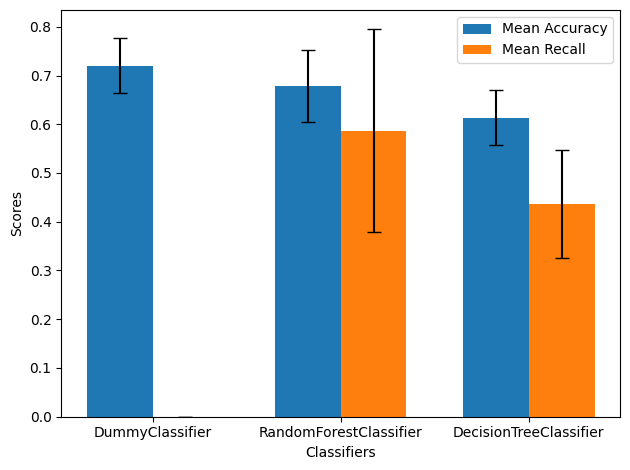

In [820]:
# Define the data
classifiers = ['DummyClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier']
mean_accuracy = [np.mean(accuracy_list[i]) for i in range(3)]
mean_recall = [np.mean(recall_list[i]) for i in range(3)]   
accuracy_ci = [confit_mean_accuracy[i] for i in range(3)]
recall_ci = [confit_mean_recall[i] for i in range(3)]

# Calculate error bars (half of the confidence interval range)
accuracy_error = [(high - low) / 2 for low, high in accuracy_ci]
recall_error = [(high - low) / 2 for low, high in recall_ci]

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(classifiers))

# Create the bar plot
fig, ax = plt.subplots()

# Bar plots for mean accuracy and recall
bars1 = ax.bar(index, mean_accuracy, bar_width, yerr=accuracy_error, label='Mean Accuracy', capsize=5)
bars2 = ax.bar(index + bar_width, mean_recall, bar_width, yerr=recall_error, label='Mean Recall', capsize=5)

# Add labels, title, and legend
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers)
ax.legend()

# Show the plot
plt.tight_layout()
if save:
    plt.savefig('Bar_plot_mean.png', dpi=300, bbox_inches='tight')
plt.show()


Bar plot of std with confidence interval

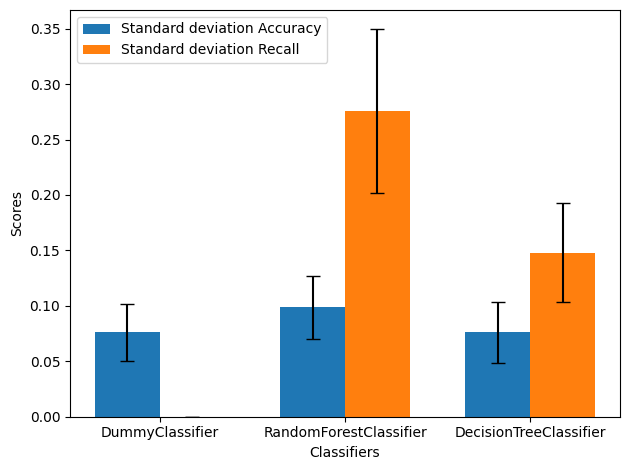

In [821]:
# Define the data
classifiers = ['DummyClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier']
mean_accuracy = [np.std(accuracy_list[i]) for i in range(3)]
mean_recall = [np.std(recall_list[i]) for i in range(3)]   
accuracy_ci = [confit_std_accuracy[i] for i in range(3)]
recall_ci = [confit_std_recall[i] for i in range(3)]

# Calculate error bars (half of the confidence interval range)
accuracy_error = [(high - low) / 2 for low, high in accuracy_ci]
recall_error = [(high - low) / 2 for low, high in recall_ci]

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(classifiers))

# Create the bar plot
fig, ax = plt.subplots()

# Bar plots for mean accuracy and recall
bars1 = ax.bar(index, mean_accuracy, bar_width, yerr=accuracy_error, label='Standard deviation Accuracy', capsize=5)
bars2 = ax.bar(index + bar_width, mean_recall, bar_width, yerr=recall_error, label='Standard deviation Recall', capsize=5)

# Add labels, title, and legend
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers)
ax.legend()

# Show the plot
plt.tight_layout()
if save:
    plt.savefig('Bar_plot_std.png', dpi=300, bbox_inches='tight')
plt.show()

Kruskal-wallis testing

In [822]:
from scipy.stats.mstats import kruskalwallis

accuracy_test = kruskalwallis(accuracy_list[0], accuracy_list[1], accuracy_list[2])
recall_test = kruskalwallis(recall_list[0], recall_list[1], recall_list[2])

results = {
    'Metric': ['Accuracy', 'Recall'],
    'H-statistic': [accuracy_test.statistic, recall_test.statistic],
    'p-value': [accuracy_test.pvalue, recall_test.pvalue]
}

Test_table = pd.DataFrame(results)
if save:
    print(Test_table.to_latex(index=False, escape=False, column_format='l|rr'))
print(Test_table)

     Metric  H-statistic   p-value
0  Accuracy     4.561644  0.102200
1    Recall    14.590037  0.000679


Post-hoc analysis on recall

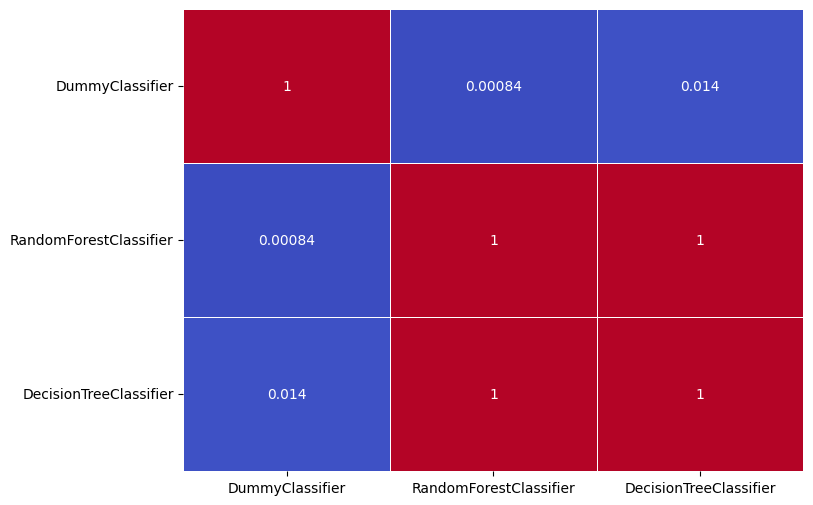

In [823]:
from scikit_posthocs import posthoc_dunn

classifiers = ['DummyClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier']

Dunn_recall = posthoc_dunn([recall_list[0], recall_list[1], recall_list[2]], val_col='value', group_col='group', p_adjust='bonferroni')

Dunn_recall.columns = classifiers
Dunn_recall.index = classifiers

plt.figure(figsize=(8, 6))
heatmap(Dunn_recall, annot=True, cmap='coolwarm', cbar=False, linewidths=.5)
if save:
    plt.savefig('Dunn_recall.png', dpi=300, bbox_inches='tight')
plt.show()
